# Spectroscopic Classification

This notebook assigns Branch et al. 2006 style subtypes to SDSS spectra.

#### Table of Contents:
1. <a href='#formatting_data'>Formatting the Data</a>: A cursory inspection of the data
1. <a href='#peak'>Closest Measurement to Peak Brightness</a>: Selecting only measurements near peak brightness
1. <a href='#plotting_classifications'>Plotting Classifications</a>: Plotting Si ii λ5972 vs Si ii λ6355

In [7]:
import math
import sys
import warnings
from datetime import datetime
from functools import reduce
from pathlib import Path

import numpy as np
import pandas as pd
from astropy.table import Table
from matplotlib import pyplot as plt
from sndata.sdss import sako18spec
from sndata.csp import dr1

sys.path.insert(0, '../')
from phot_class.spectra import tabulate_spectral_properties, dust_map, bin_spectrum

dr1.download_module_data()
sako18spec.download_module_data()

# Output directory for figures
fig_dir = Path('./notebook_figs/pew_measurements')
fig_dir.mkdir(exist_ok=True, parents=True)


/anaconda3/envs/phot_class/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


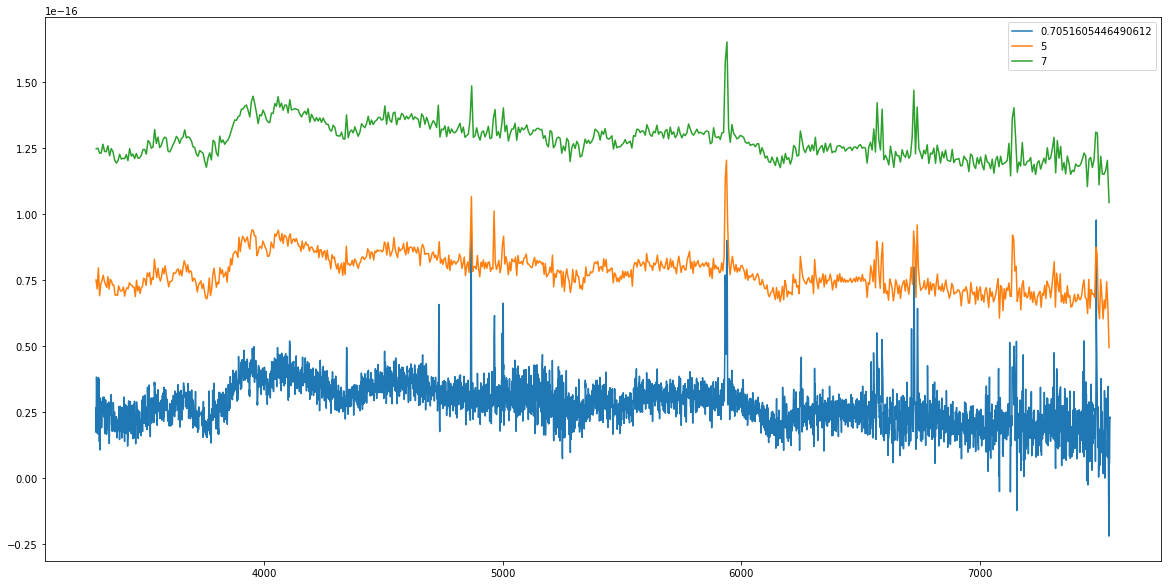

In [88]:
data = sako18spec.get_data_for_id('5635')

wave = data['wavelength'] / (1 + z)
flux = data['flux']
z = data.meta['z']

min_wave = np.floor(np.min(wave))
max_wave = np.floor(np.max(wave))

plt.figure(figsize=(20, 10))
for i, size in enumerate((wave[1] - wave[0], 5, 7)):
    bins = np.arange(min_wave, max_wave + 1, size) 
    hist, bin_edges = np.histogram(wave, bins=bins, weights=flux)
    bin_centers = bin_edges[:-1] + ((bin_edges[1] - bin_edges[0]) / 2)
    
    bin_means = (np.histogram(wave, bins=bins, weights=flux)[0] /
                 np.histogram(wave, bins)[0])
    
    plt.plot(bin_centers, bin_means + 5 * i * 1e-17, label=size)
    
plt.legend()


## Formatting the data <a id='formatting_data'></a>

We start by reading in measurements from external publications.

In [ ]:
folatelli_13 = dr1.load_table(6).to_pandas()
branch_06 = pd.DataFrame({
    'obj_id': ['1981B', '1984A', '1986G', '1989B', '1990N', '1991M', '1991T', '1991bg', '1992A', '1994D', '1194ae', '1996X', '1997cn', '1998ag', '1998bu', '1999aw', '1999by', '1999ee', '2000cx', '2001ay', '2001el', '2002bf', '2002bo', '2002cx'],
    'pw7': [127, 204, 126, 124, 88, 137, 29, 92, 107, 96, 89, 87, 101, 78, 94, 58, 95, 82, 51, 150, 95, 171, 146, 18 ],
    'pw6': [17, 23, 33, 20, 12, 19, 0, 49, 19, 19, 7, 17, 45, 12, 16, 1, 46, 5, 2, 8, 16, 10, 11, 0]
})


Next we read in spectroscopic measurements from the analysis pipeline. We include results determined using a range of resampling sizes.

In [ ]:
@np.vectorize
def calc_julian_date(date):
    """
    Convert a datetime object into julian float.
    
    Args:
        date (str): The date to convert in %Y-%m-%d format

    Returns:
        The Julian date as a float
    """

    
    date = datetime.strptime(date, '%Y-%m-%d')
    julian_datetime = (
        367 * date.year - 
        int((7 * (date.year + int((date.month + 9) / 12.0))) / 4.0) + 
        int((275 * date.month) / 9.0) + date.day + 
        1721013.5 + 
        (date.hour + date.minute / 60.0 + date.second / math.pow(60, 2)) / 24.0 - 
        0.5 * math.copysign(1, 100 * date.year + date.month - 190002.5) + 0.5
    )

    return julian_datetime


def read_spec_results(path):
    """Read in spectroscopic measurements from the analysis pipeline
    
    Args:
        path (str): The path of the ecsv file to read
        
    Returns:
        A Pandas DataFrame
    """

    # Read in pipeline results
    spec_class = Table.read(path).to_pandas()
    spec_class.set_index(['obj_id', 'feat_name'], inplace=True)
    spec_class['jd'] = calc_julian_date(spec_class.date)
    
    # Get time of peak brightness
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        master = sako18spec.load_table('master').to_pandas()
        master = master.rename(columns={'CID': 'obj_id'}).set_index('obj_id')

    # Calculate days since maximum
    peak_jd = master.MJDatPeakrmag + 2400000.5
    spec_class['days'] = spec_class.jd - peak_jd
    
    return spec_class


In [ ]:
results_dir = Path('/Users/daniel/Github/Photometric-Classification/results/')

# Data for 0, 2, and 5 resampling steps
n0_spec = read_spec_results(results_dir / 'spec_class/sdss_sako18spec_3_1_0.ecsv')
n2_spec = read_spec_results(results_dir / 'spec_class/sdss_sako18spec_3_1_2.ecsv')
n5_spec = read_spec_results(results_dir / 'spec_class/sdss_sako18spec_3_1_5.ecsv')


In [ ]:
n5_spec.head()

We check the reasons why some of our calculations failed.

In [ ]:
n5_spec[n5_spec.pew.isna()].msg.value_counts()


We also check the number of measurement available for each target.

In [ ]:
(n5_spec.sid.value_counts() / 2).hist()
plt.title('Number of spectra per object (Not including host)')
plt.ylabel('Number of Targets')
plt.xlabel('Number of Spectra')
plt.show()


## Closest Measurements to Peak Brightness <a id='peak'></a>

Since some objects have multiple measurements, we chose the value closes to peak brightness.


In [ ]:
def get_tmax_pew(spec_data):
    """Keep only pew measurements performed nearest tmax
    
    Args:
        spec_data     (DataFrame): Measurements from the analysis pipeline
    
    Returns:
        A pandas DataFrame
    """
    
    features = spec_data.index.get_level_values('feat_name').unique()
    data_frames = []

    for feat_name in features:
        feat_data = spec_data.xs(feat_name, level='feat_name')
        feat_data['feat_name'] = feat_name
        feat_data.set_index('feat_name', append=True, inplace=True)
        
        feat_data['sort'] = feat_data.days.abs()         
        feat_data = feat_data.sort_values(by='sort')
        feat_data = feat_data[~feat_data.index.duplicated()]
        feat_data = feat_data.drop(axis=1, labels='sort')
        data_frames.append(feat_data)
    
    return pd.concat(data_frames)


In [ ]:
n0_peak = get_tmax_pew(n0_spec)
n2_peak = get_tmax_pew(n2_spec)
n5_peak = get_tmax_pew(n5_spec)

## Plotting Classifications <a id='plotting_classifications'></a>

We plot the pEW of Si ii at λ5972 vs λ6355.


In [ ]:
def get_colors(pw6, pw7):
    """Get the color of each point bassed on its coordinates
    
    Args:
        pw6 (ndarray): Array of EW measurements for feature 6
        pw7 (ndarray): Array of EW measurements for feature 7
        
    Returns:
        A 2d array of RGB values
    """
    
    color = np.ones((len(pw6), 4))
    color[:, 0: 3] = 0  # Default to black
    color[pw6 > 30] = 0, 0, 1, 1  # Blue
    color[(pw6 < 30) & (pw7 > 105)] = 1, 0, 0, 1  # Red
    color[pw7 < 70] = 0, 128 / 255, 0, 1  # Green

    return color

def subplot_published_classes(axis):
    """Plot Si ii pEW at λ5972 vs λ6355 from CSP and Branch 2006
    
    Args:
        axis (Axis): A matplotlib axis
    """

    axis.scatter(
        branch_06.pw7, 
        branch_06.pw6, 
        marker='D',
        facecolor='none', 
        edgecolor=get_colors(branch_06.pw6, branch_06.pw7),
        zorder=2,
        alpha=.5,
        label='Branch 2006'
    )

    axis.scatter(
        folatelli_13.pW7, 
        folatelli_13.pW6, 
        marker='v',
        facecolor='none', 
        edgecolor=get_colors(folatelli_13.pW6, folatelli_13.pW7),
        zorder=2,
        alpha=.5,
        label='Folatelli 2013'
    )

def plot_si_ratio(spec_data, snr_ratios=(1, 2, 3), plot_external_data=True):
    """Plot the pW6 vs pW7 silicon pEw ratios
    
    Args:
        spec_data     (DataFrame): Measurements from the analysis pipeline
        plot_external_data (bool): Whether to plot data from CSP and Branch 2006
        
    Returns:
        A matplotlib figure
        An array of matplotlib axes
    """
    
    # Keep only Type Ia spectra
    si_data = spec_data[spec_data.type.isin(['Ia', 'Ia-pec', 'Ia?'])].dropna(subset=['pew'])
    si_data = si_data[si_data.days.abs() < 7]
    
    num_subplots = len(snr_ratios)
    fig, axes = plt.subplots(1, num_subplots, figsize=(num_subplots * 6, 6), sharex=True, sharey=True)  
    flat_ax = [axes] if num_subplots == 1 else axes.flatten()
    for snr, axis in zip(snr_ratios, flat_ax):
        
        # Keep only data with both pw6 and pw7 measurements greater than snr
        good_snr = si_data[si_data.pew / si_data.pew_samperr  >= snr]
        pw6 = good_snr.xs('pW6', level='feat_name')[['pew', 'pew_samperr']]
        pw7 = good_snr.xs('pW7', level='feat_name')[['pew', 'pew_samperr']]
        plot_data = pd.merge(pw6, pw7, on='obj_id', suffixes=('_pw6', '_pw7'))
        
        axis.errorbar(
            x=plot_data.pew_pw7, 
            y=plot_data.pew_pw6, 
            xerr=plot_data.pew_samperr_pw7, 
            yerr=plot_data.pew_samperr_pw6, 
            linestyle='', 
            ecolor='grey', 
            color='grey',
            alpha=.3, 
            zorder=0)
        
        if plot_external_data:
            subplot_published_classes(axis)
        
        # Isolate each subtype
        cl = plot_data[plot_data.pew_pw6 > 30]
        bl = plot_data[(plot_data.pew_pw6 < 30) & (plot_data.pew_pw7 > 105)]
        ss = plot_data[plot_data.pew_pw7 < 70]
        cn = plot_data[(plot_data.pew_pw6 <= 30) & (70 <= plot_data.pew_pw7) & (plot_data.pew_pw7 <= 105)]
        
        axis.scatter(cl.pew_pw7, cl.pew_pw6, color='C0', zorder=1, label='Cool')
        axis.scatter(bl.pew_pw7, bl.pew_pw6, color='C3', zorder=1, label='Broad Line')
        axis.scatter(ss.pew_pw7, ss.pew_pw6, color='C2', zorder=1, label='Shallow Silicon')
        axis.scatter(cn.pew_pw7, cn.pew_pw6, color='k', zorder=1, label='Core Normal')
        
        axis.set_xlabel('Si ii λ6355', fontsize=14)
        axis.set_title(f'SNR > {snr}')
        
    flat_ax[0].set_xlim(-10, 500)
    flat_ax[0].set_ylim(-10, 200)
    flat_ax[0].set_ylabel('Si ii λ5972', fontsize=14) 
    flat_ax[-1].legend()
    return fig, flat_ax


In [ ]:
fig, axes = plot_si_ratio(n0_peak)
fig.suptitle(f'0 Sampling Iterations')
plt.savefig(fig_dir / '0_iterations.pdf')
plt.show()


In [ ]:
fig, axes = plot_si_ratio(n2_peak)
fig.suptitle(f'2 Sampling Iterations')
plt.savefig(fig_dir / '2_iterations.pdf')
plt.show()


In [ ]:
fig, axes = plot_si_ratio(n5_peak, (0, 1, 2, 3))
fig.suptitle(f'5 Sampling Iterations')
plt.savefig(fig_dir / '5_iterations.pdf')
plt.show()


In [ ]:
fig, axes = plot_si_ratio(n5_peak, (0, ), False)
axes[0].set_title('')
axes[0].set_xlim(0, 350)
axes[0].set_ylim(0, 120)
plt.savefig(fig_dir / '5_iterations_snr_eq_1.pdf')
plt.show()


We note the two outlier points with high pEW are noisy spectra.

In [ ]:
n5_peak.loc[['5635', '6780']]


In [ ]:
for obj_id in ('5635', '6780'):
    fig, axis = plt.subplots(figsize=(20, 10))
    target_data = sako18spec.get_data_for_id(obj_id)
    z = target_data.meta['z']
    wave = target_data['wavelength'] / (1 + z)
    
    axis.plot(wave, target_data['flux'], lw=.5, label=obj_id)
    axis.set_xlabel('Wavelength')
    axis.set_ylabel('Flux')
    axis.legend()
    plt.show()
